### install BERT 

In [ ]:
!pip install bert-extractive-summarizer

Request acsess from drive

In [ ]:
from pathlib import Path
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# Import libraries


In [ ]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
from collections import defaultdict
from pathlib import Path

import nltk
nltk.download('stopwords')
nltk.download('punkt')
nltk.download('wordnet')
from nltk.tokenize import word_tokenize
from nltk.tokenize import RegexpTokenizer
from nltk.corpus import stopwords
import re
from nltk.stem import WordNetLemmatizer 

#models
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.cluster import KMeans
#metrics
from sklearn.metrics import accuracy_score
from sklearn.model_selection import cross_val_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import plot_confusion_matrix
from sklearn.metrics import classification_report
from sklearn.model_selection import train_test_split
from sklearn.metrics import silhouette_samples, silhouette_score
from yellowbrick.cluster import SilhouetteVisualizer
from sklearn.manifold import TSNE


from summarizer import Summarizer,TransformerSummarizer
from transformers import pipeline
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
import pickle
import wordcloud
from wordcloud import WordCloud
import collections
from collections import Counter, defaultdict

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


# preprocossing on the data

In [ ]:
label = ['sport' , 'business' , 'tech' , 'entertainment', 'politics']
pathes = ["/content/drive/My Drive/news_article/sport",
          "/content/drive/MyDrive/news_article/business",
          "/content/drive/My Drive/news_article/tech",
          "/content/drive/My Drive/news_article/entertainment",
          "/content/drive/My Drive/news_article/politics"]

all_articles = []
labels = []
lemmatizer = WordNetLemmatizer()
stop_words = set(stopwords.words('english'))

for catogry,label in zip(pathes, label) :
  my_dir_path = catogry
  #results = defaultdict(list)
  for file in Path(my_dir_path).iterdir(): 
    with open(file, "r" ,encoding ='unicode_escape') as file_open:
      articles = file_open.read().lower()         #.decode('utf8')   
      # Removing Square Brackets and Extra Spaces
      tokenizer = RegexpTokenizer('\[[0-9]*\]')
      #articles = tokenizer.tokenize(articles)
      #print(type(articles[0]))
      article_text = re.sub(r'\[[0-9][a-z]*\]', ' ', articles)  
      article_text = re.sub(r'\s+', ' ', article_text)
      #-----------------Removing special characters and digits
      formatted_article_text = re.sub(r'\W',' ',article_text)
      formatted_article_text = re.sub(r'\d',' ',formatted_article_text)
      formatted_article_text = re.sub(r'\s+',' ',formatted_article_text)
              #---------stop_words-------------------------------------------
      text_tokens = word_tokenize(formatted_article_text)
      tokens_without_sw = [lemmatizer.lemmatize(word) for word in text_tokens if word not in stop_words]
      all_article = ' '.join(tokens_without_sw)
  #             #---------------------------------------------------------
      all_articles.append(all_article)
      labels.append(label)
      df=pd.DataFrame((zip(all_articles ,labels )),columns =['articles' , 'labels'])
  #frams.append(df)
  #full_df = pd.concat(frams)

In [ ]:
df.head()

,articles,labels
0,dibaba break world record ethiopia tirunesh di...,sport
1,sullivan commits dublin race sonia sullivan se...,sport
2,colour gardener storm win britain jason garden...,sport
3,isinbayeva claim new world best pole vaulter y...,sport
4,hansen delay return british triple jumper ashi...,sport


# summarization model

In [ ]:
def summery_text (new_text):
  summarizer = pipeline("summarization")
  summarized = summarizer(new_text, min_length=30, max_length=50)
  return summarized

In [ ]:
article_summery = []
for article in df['articles']:
  summarized = summery_text(article)
  article_summery.append(summarized)

No model was supplied, defaulted to sshleifer/distilbart-cnn-12-6 (https://huggingface.co/sshleifer/distilbart-cnn-12-6)
No model was supplied, defaulted to sshleifer/distilbart-cnn-12-6 (https://huggingface.co/sshleifer/distilbart-cnn-12-6)
No model was supplied, defaulted to sshleifer/distilbart-cnn-12-6 (https://huggingface.co/sshleifer/distilbart-cnn-12-6)
No model was supplied, defaulted to sshleifer/distilbart-cnn-12-6 (https://huggingface.co/sshleifer/distilbart-cnn-12-6)
No model was supplied, defaulted to sshleifer/distilbart-cnn-12-6 (https://huggingface.co/sshleifer/distilbart-cnn-12-6)
No model was supplied, defaulted to sshleifer/distilbart-cnn-12-6 (https://huggingface.co/sshleifer/distilbart-cnn-12-6)
No model was supplied, defaulted to sshleifer/distilbart-cnn-12-6 (https://huggingface.co/sshleifer/distilbart-cnn-12-6)
No model was supplied, defaulted to sshleifer/distilbart-cnn-12-6 (https://huggingface.co/sshleifer/distilbart-cnn-12-6)
No model was supplied, defaulted

### feature engineering (TF-IDF) then split into train&test

In [ ]:
all_sentences = df['articles']
tfidf_model = TfidfVectorizer()
tfidf_vect = tfidf_model.fit_transform(all_sentences)
X = tfidf_vect.toarray()
y = df['labels']
# Split dataset into training set and test set
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

In [ ]:
len(X_train)

40

### method for print accurcy 

In [ ]:
def print_accuracy(model, y_test, pred, x_test ):
    acc = accuracy_score(y_test, pred)*100
    print("Accuracy: " , acc , "%")
    print('\nClassification Report:\n')
    print(classification_report(y_test, pred))
    
    print("---------------------------------------------\n")
    
    fig, ax = plt.subplots(figsize=(7, 7))
    print('\nConfusion Matrix:')
    plot_confusion_matrix(model, x_test, y_test,
                          xticks_rotation='horizontal',
                          ax=ax, cmap=plt.cm.Blues)
    plt.title('Confusion matrix')
    plt.show()
    
    return acc

### method for build model classification

In [ ]:
def build_model(model, x_train, y_train, x_test, y_test):
    
    model.fit(x_train, y_train)
    
    model_pred = model.predict(x_test)
    
    print_accuracy(model, y_test, model_pred, x_test)
    
    return model_pred, model

### adabost classification model

Accuracy:  30.0 %

Classification Report:

               precision    recall  f1-score   support

     business       0.17      0.50      0.25         2
entertainment       0.00      0.00      0.00         2
     politics       1.00      1.00      1.00         1
        sport       0.33      0.50      0.40         2
         tech       0.00      0.00      0.00         3

     accuracy                           0.30        10
    macro avg       0.30      0.40      0.33        10
 weighted avg       0.20      0.30      0.23        10

---------------------------------------------


Confusion Matrix:


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py

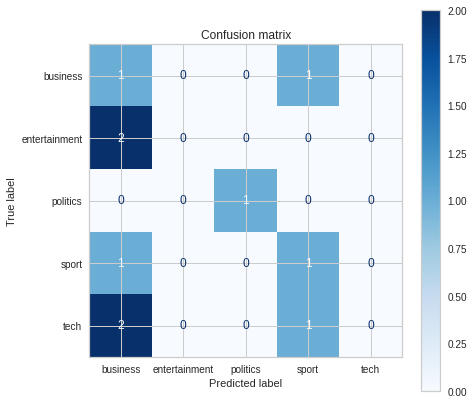

In [ ]:
ada_model = AdaBoostClassifier(n_estimators=200, random_state=0)
ada_pred = build_model(ada_model, X_train, y_train, X_test, y_test)

### Knn classification model

Accuracy:  90.0 %

Classification Report:

               precision    recall  f1-score   support

     business       0.67      1.00      0.80         2
entertainment       1.00      1.00      1.00         2
     politics       1.00      1.00      1.00         1
        sport       1.00      1.00      1.00         2
         tech       1.00      0.67      0.80         3

     accuracy                           0.90        10
    macro avg       0.93      0.93      0.92        10
 weighted avg       0.93      0.90      0.90        10

---------------------------------------------


Confusion Matrix:


/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


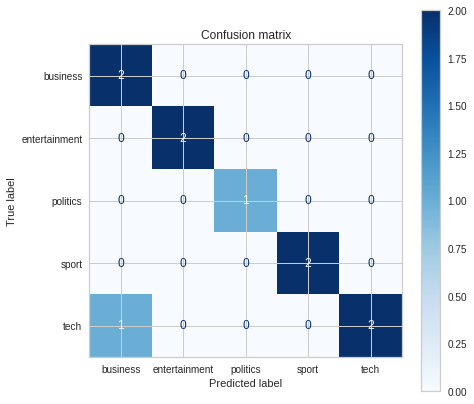

In [ ]:
knn = KNeighborsClassifier(n_neighbors=3)
knn_pred, knn_model = build_model(knn, X_train,y_train , X_test , y_test)

Counter({'tech': 3, 'business': 2, 'sport': 2, 'entertainment': 2, 'politics': 1})


<BarContainer object of 5 artists>

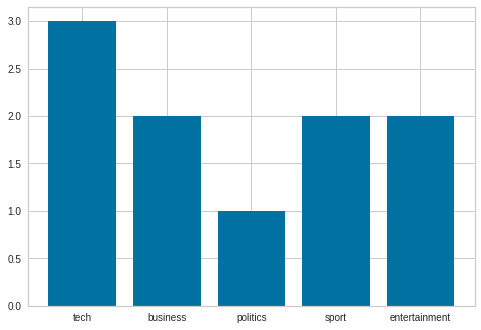

In [ ]:
counter_test = Counter(y_test)
print(counter_test)
plt.bar(counter_test.keys(), counter_test.values())
#y_test

Counter({'business': 3, 'sport': 2, 'tech': 2, 'entertainment': 2, 'politics': 1})


<BarContainer object of 5 artists>

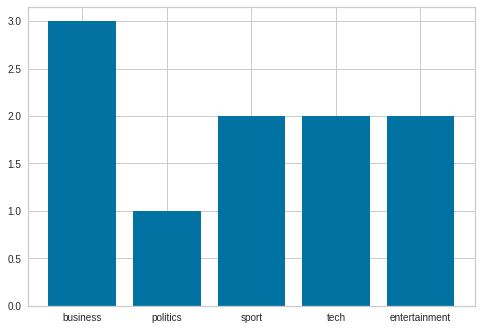

In [ ]:
counter_knn = Counter(knn_pred)
print(counter_knn)
plt.bar(counter_knn.keys(), counter_knn.values())

### decitiontree model

Accuracy:  50.0 %

Classification Report:

               precision    recall  f1-score   support

     business       0.33      0.50      0.40         2
entertainment       0.40      1.00      0.57         2
     politics       1.00      1.00      1.00         1
        sport       1.00      0.50      0.67         2
         tech       0.00      0.00      0.00         3

     accuracy                           0.50        10
    macro avg       0.55      0.60      0.53        10
 weighted avg       0.45      0.50      0.43        10

---------------------------------------------


Confusion Matrix:


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py

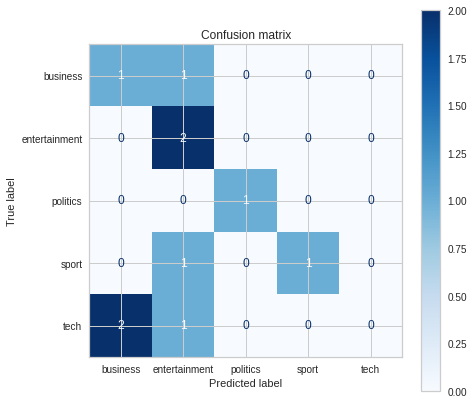

In [ ]:
dt_model = DecisionTreeClassifier()
dt_pred = build_model(dt_model, X_train,y_train , X_test , y_test)

add the result summarization to the dataframe  

In [ ]:
df['summary'] = article_summery
df.head()

,articles,labels,summary
0,dibaba break world record ethiopia tirunesh di...,sport,[{'summary_text': ' dibaba break world record ...
1,sullivan commits dublin race sonia sullivan se...,sport,[{'summary_text': ' km km km make debut mass p...
2,colour gardener storm win britain jason garden...,sport,[{'summary_text': ' britain jason gardener sho...
3,isinbayeva claim new world best pole vaulter y...,sport,[{'summary_text': ' yelena isinbayeva broke in...
4,hansen delay return british triple jumper ashi...,sport,[{'summary_text': ' british triple jumper ashi...


In [ ]:
summary_values= []
for summary in df['summary']:
  summary_values.append(list(summary[0].values()))
str_lst = []
for i in summary_values:
  str_lst.append(i[0])
df_summary=pd.DataFrame((zip(all_articles ,str_lst,labels )),columns =['articles','summary' ,'labels'])
df_summary.head()


,articles,summary,labels
0,dibaba break world record ethiopia tirunesh di...,dibaba break world record ethiopia tirunesh d...,sport
1,sullivan commits dublin race sonia sullivan se...,km km km make debut mass participation mass p...,sport
2,colour gardener storm win britain jason garden...,britain jason gardener shook upset stomach wi...,sport
3,isinbayeva claim new world best pole vaulter y...,yelena isinbayeva broke indoor world record c...,sport
4,hansen delay return british triple jumper ashi...,british triple jumper ashia hansen ruled come...,sport


In [ ]:
len(knn_pred)

10

In [ ]:
df_class=pd.DataFrame((zip(all_articles ,str_lst ,knn_pred )),columns =['articles','summary' ,'class_label'])
df_class.head()

,articles,summary,class_label
0,dibaba break world record ethiopia tirunesh di...,dibaba break world record ethiopia tirunesh d...,business
1,sullivan commits dublin race sonia sullivan se...,km km km make debut mass participation mass p...,business
2,colour gardener storm win britain jason garden...,britain jason gardener shook upset stomach wi...,business
3,isinbayeva claim new world best pole vaulter y...,yelena isinbayeva broke indoor world record c...,politics
4,hansen delay return british triple jumper ashi...,british triple jumper ashia hansen ruled come...,sport


Dimentionality reduction tsne on tfidf

In [ ]:
tsne_tfidf = TSNE(n_components=2, verbose=1, random_state=123)
new_tf_tsne = tsne_tfidf.fit_transform(X)

/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:783: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:793: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  FutureWarning,


[t-SNE] Computing 49 nearest neighbors...
[t-SNE] Indexed 50 samples in 0.001s...
[t-SNE] Computed neighbors for 50 samples in 0.003s...
[t-SNE] Computed conditional probabilities for sample 50 / 50
[t-SNE] Mean sigma: 0.290863
[t-SNE] KL divergence after 250 iterations with early exaggeration: 50.546356
[t-SNE] KL divergence after 1000 iterations: 0.355114


### kmean cluster model

In [ ]:
kmeans = KMeans(n_clusters = 5, n_init = 5, random_state=0)
clusters_label = kmeans.fit_predict(new_tf_tsne)
print(np.unique(clusters_label))
print(len(clusters_label))

[0 1 2 3 4]
50


Counter({4: 13, 0: 10, 3: 10, 2: 9, 1: 8})


<BarContainer object of 5 artists>

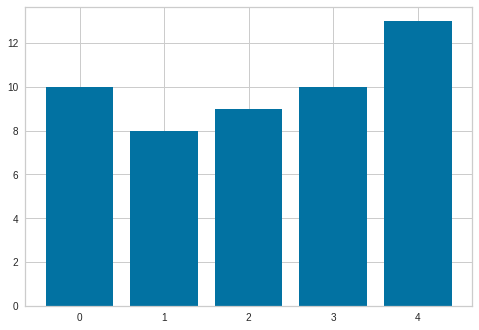

In [ ]:
counter_kmeans = Counter(kmeans.labels_)
print(counter_kmeans)
plt.bar(counter_kmeans.keys(), counter_kmeans.values())

#### silhouette_score

In [ ]:
score_tfidf_kmeans = silhouette_score(new_tf_tsne, clusters_label)
score_tfidf_kmeans

0.3343995

SilhouetteVisualizer(ax=<matplotlib.axes._subplots.AxesSubplot object at 0x7f0ccf497bd0>,
                     colors='yellowbrick',
                     estimator=KMeans(n_clusters=5, n_init=5, random_state=0))

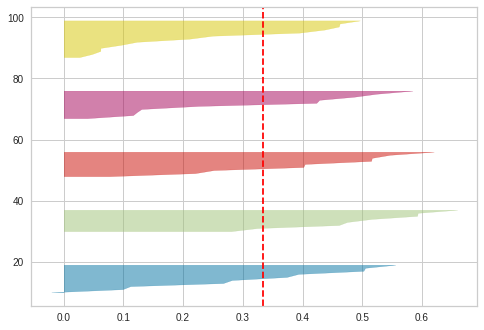

In [ ]:
visualizer_tfidf = SilhouetteVisualizer(kmeans, colors='yellowbrick')
visualizer_tfidf.fit(new_tf_tsne) 

In [ ]:
df_cluster=pd.DataFrame((zip(all_articles ,str_lst,clusters_label )),columns =['articles','summary' ,'clusters_label'])
df_cluster.head()

,articles,summary,clusters_label
0,dibaba break world record ethiopia tirunesh di...,dibaba break world record ethiopia tirunesh d...,2
1,sullivan commits dublin race sonia sullivan se...,km km km make debut mass participation mass p...,0
2,colour gardener storm win britain jason garden...,britain jason gardener shook upset stomach wi...,2
3,isinbayeva claim new world best pole vaulter y...,yelena isinbayeva broke indoor world record c...,2
4,hansen delay return british triple jumper ashi...,british triple jumper ashia hansen ruled come...,2


### split dataset based on cluster label

In [ ]:
y_cluster = df_cluster['clusters_label']
# Split dataset into training set and test set
Xx_train, Xx_test, yy_train, yy_test = train_test_split(X, y_cluster, test_size=0.3, random_state=0)

## KNN model based on cluster label

Accuracy:  80.0 %

Classification Report:

              precision    recall  f1-score   support

           0       0.33      0.50      0.40         2
           1       1.00      1.00      1.00         5
           2       1.00      1.00      1.00         2
           3       0.50      0.50      0.50         2
           4       1.00      0.75      0.86         4

    accuracy                           0.80        15
   macro avg       0.77      0.75      0.75        15
weighted avg       0.84      0.80      0.82        15

---------------------------------------------


Confusion Matrix:


/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


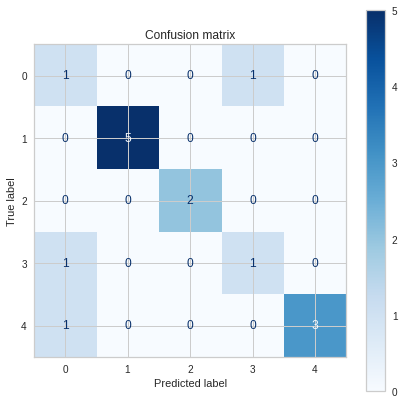

In [ ]:
knn_pred1, knn_model1 = build_model(knn, Xx_train, yy_train , Xx_test , yy_test)

### test new article on the models

In [ ]:
new_article = '''
 Court halts Mark Morrison album

Premiership footballer and record company boss Kevin Campbell has gained a court injunction stopping R&B singer Mark Morrison from releasing an album.

The Everton striker signed Morrison to his fledging 2 Wikid Records label and claims he spent thousands of pounds producing his album Innocent Man. Now he is attempting to prevent Morrison releasing the album on Monday through another label. But Morrison vowed to ignore the order, saying "no judge is gonna stop me".

Morrison, who is now as well known for his brushes with the law than his music career, rose to fame with the 1996 single Return of the Mack.

But the Leicester singer has struggled to repeat its success following two spells in jail. One was for hiring a stand-in to complete his community service for possession of a stun gun and three-months following a nightclub fracas. He signed to Mr Campbell's label a year ago and has released one single, with the label saying the album was due for release on 24 January. But Mr Campbell said he learned that Morrison planned to release the album through Jet Star, which is advertising it on its website. Mr Campbell said: "I'm glad we were granted the injunction but I'm completely gutted that we have had to go that far. "Mark Morrison was given everything he asked for by 2 Wikid but it seems that he couldn't help but return to his old ways.

"I've worked hard to realise my ambition in football but had hoped that my future career would be in the music business. "I have always dreamt of starting a record label but now Mark Morrison has spoilt that dream for me. There is no loyalty in this business - just greed."

But Morrison is determined the album will be released on Monday. He said: "The injunction is ludicrous. "I signed a new deal with a new record company because I was not getting the support I needed from 2 Wikid. "I was with that label for a year and in that time released just one record, which was not properly promoted. He added: "The whole world is waiting for this album and it will come out on December 27. No injunction or judge will stop it. The Mack will return." The case is set to be heard in the High Court on 20 December.


'''

In [ ]:
new_summ = summery_text(new_article)

No model was supplied, defaulted to sshleifer/distilbart-cnn-12-6 (https://huggingface.co/sshleifer/distilbart-cnn-12-6)


In [ ]:
new_summer = list(new_summ[0].values())
str1 = ''.join(str(e) for e in new_summer)
str1

' Everton striker signed Morrison to his 2 Wikid Records label and claims he spent thousands of pounds producing his album Innocent Man . Now he is attempting to prevent Morrison releasing the album on Monday through another label . But Morrison vows to ignore the order'

# matching new article with cluter label in df

In [ ]:
vectorizer_article = TfidfVectorizer(decode_error="replace")
article_vect = vectorizer_article.fit(df['articles'])
article_transformed = vectorizer_article.transform([new_article])

In [ ]:
new_text = article_transformed.toarray()

### predict cluster number for new_article

In [ ]:
out_put1 = knn_model1.predict(new_text)
out_put1

array([0])

### error anlysis

#### wordcloud on actual article


 WordCloud of book sport



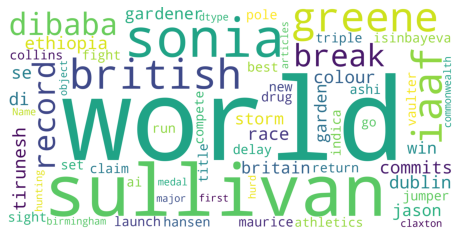


 WordCloud of book business



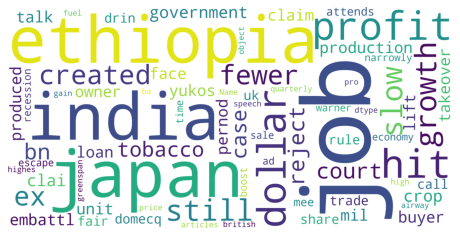


 WordCloud of book tech



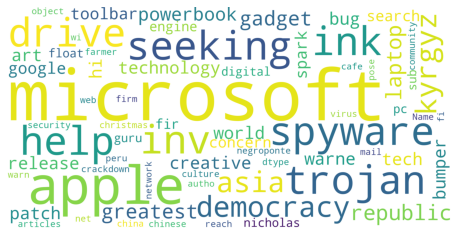


 WordCloud of book entertainment



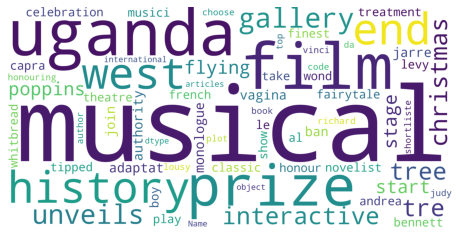


 WordCloud of book politics



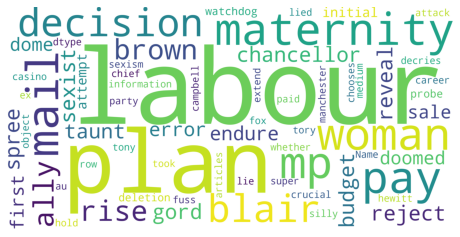

In [ ]:
for label in df['labels'].unique():
    corpus = df[df["labels"]==label]["articles"]
    lst_tokens = nltk.tokenize.word_tokenize(corpus.str.cat(sep=" "))
    #wordcloud 
    print(f"\n WordCloud of book {label}\n")
    wc = wordcloud.WordCloud(background_color='white', max_words=150,width=1200, height=600, margin=4,scale=2, 
                          max_font_size=None)
    
    wc = wc.generate(str(corpus))
    fig = plt.figure(num=1)
    plt.axis('off')
    plt.imshow(wc, cmap=None)
    plt.show() 

### wordcloud on summariezed article


 WordCloud of book sport



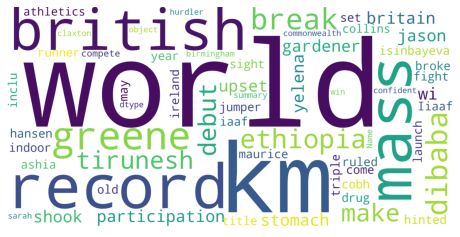


 WordCloud of book business



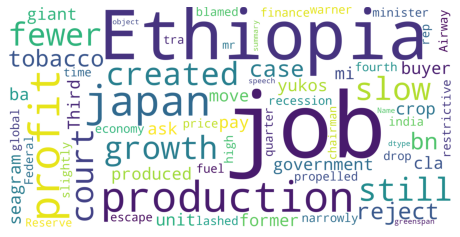


 WordCloud of book tech



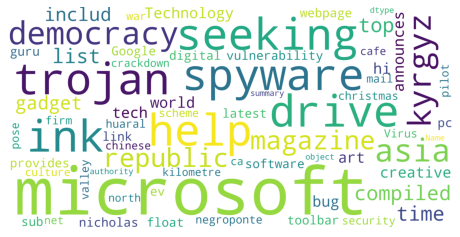


 WordCloud of book entertainment



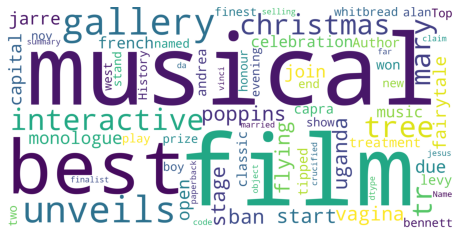


 WordCloud of book politics



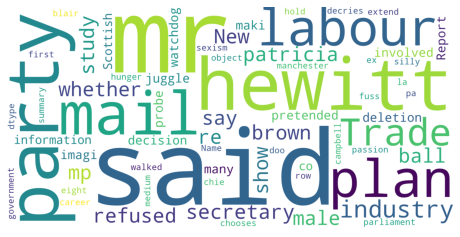

In [ ]:
for label in df_summary['labels'].unique():
    corpus = df_summary[df_summary["labels"]==label]["summary"]
    lst_tokens = nltk.tokenize.word_tokenize(corpus.str.cat(sep=" "))
    #wordcloud 
    print(f"\n WordCloud of book {label}\n")
    wc = wordcloud.WordCloud(background_color='white', max_words=150,width=1200, height=600, margin=4,scale=2, 
                          max_font_size=None)
    
    wc = wc.generate(str(corpus))
    fig = plt.figure(num=1)
    plt.axis('off')
    plt.imshow(wc, cmap=None)
    plt.show() 

### wordcloud after classification


 WordCloud of book business



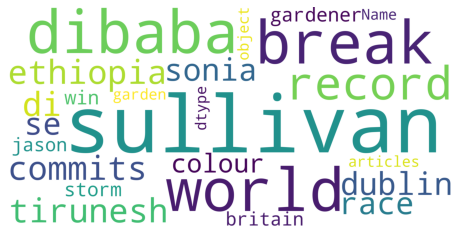


 WordCloud of book politics



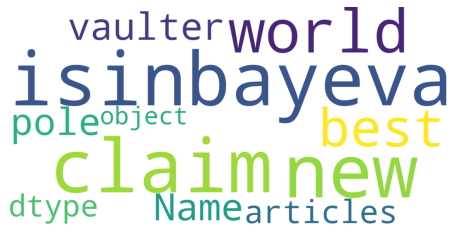


 WordCloud of book sport



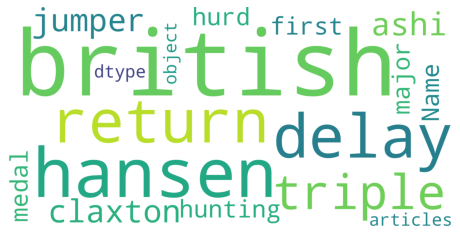


 WordCloud of book tech



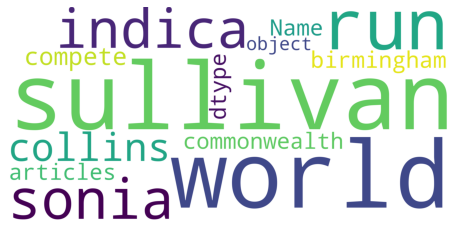


 WordCloud of book entertainment



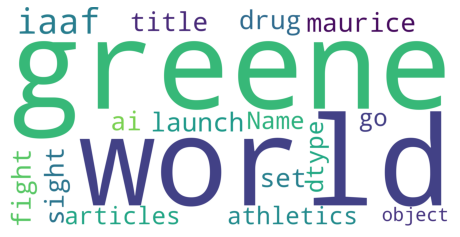

In [ ]:
for label in df_class['class_label'].unique():
    corpus = df_class[df_class["class_label"]==label]["articles"]
    lst_tokens = nltk.tokenize.word_tokenize(corpus.str.cat(sep=" "))
    #wordcloud 
    print(f"\n WordCloud of book {label}\n")
    wc = wordcloud.WordCloud(background_color='white', max_words=150,width=1200, height=600, margin=4,scale=2, 
                          max_font_size=None)
    
    wc = wc.generate(str(corpus))
    fig = plt.figure(num=1)
    plt.axis('off')
    plt.imshow(wc, cmap=None)
    plt.show() 

### wordcloud after clustering


 WordCloud of book 2



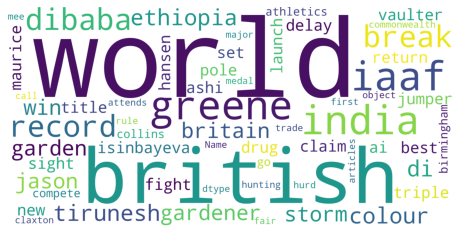


 WordCloud of book 0



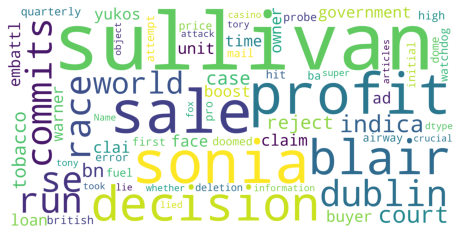


 WordCloud of book 3



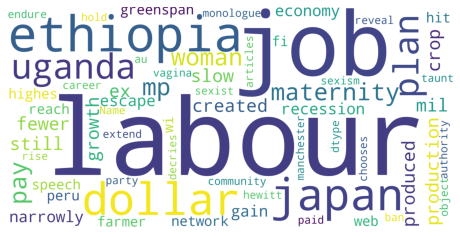


 WordCloud of book 4



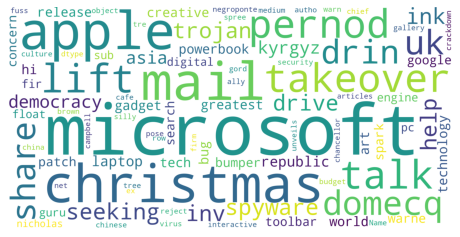


 WordCloud of book 1



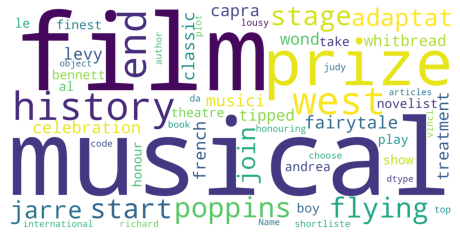

In [ ]:
for label in df_cluster['clusters_label'].unique():
    corpus = df_cluster[df_cluster["clusters_label"]==label]["articles"]
    lst_tokens = nltk.tokenize.word_tokenize(corpus.str.cat(sep=" "))
    #wordcloud 
    print(f"\n WordCloud of book {label}\n")
    wc = wordcloud.WordCloud(background_color='white', max_words=150,width=1200, height=600, margin=4,scale=2, 
                          max_font_size=None)
    
    wc = wc.generate(str(corpus))
    fig = plt.figure(num=1)
    plt.axis('off')
    plt.imshow(wc, cmap=None)
    plt.show() 

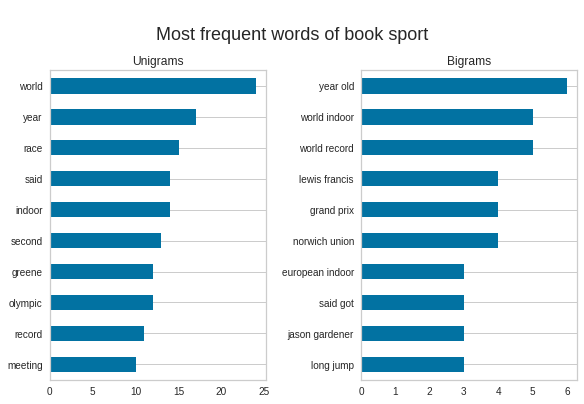

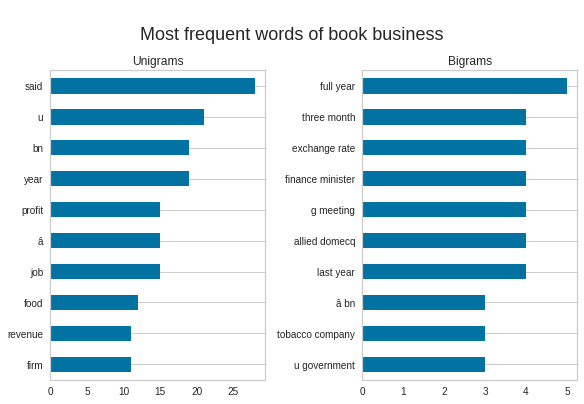

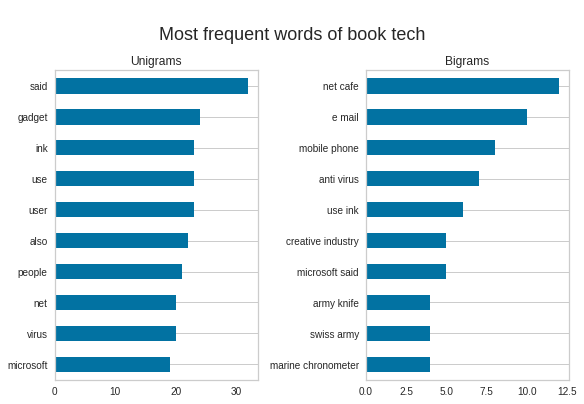

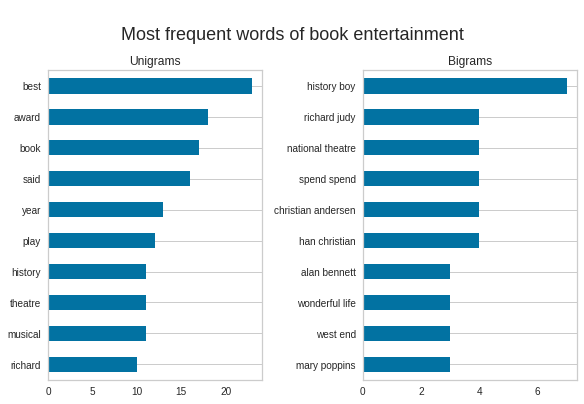

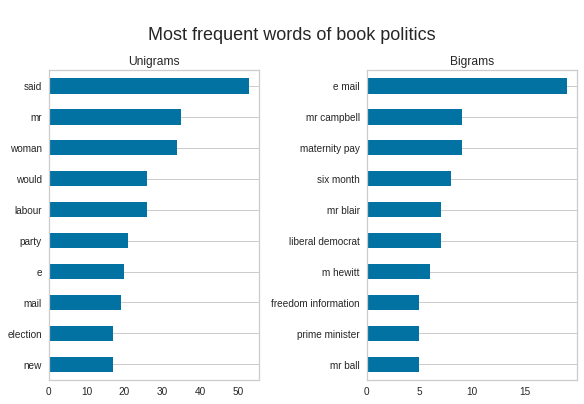

In [ ]:

df_top_word = [ ]
top= 10
for label in df['labels'].unique():
    corpus = df[df["labels"]==label]["articles"]
    lst_tokens = nltk.tokenize.word_tokenize(corpus.str.cat(sep=" "))
    fig, ax = plt.subplots(nrows=1, ncols=2,constrained_layout=True)
    fig.suptitle(f"\n Most frequent words of book {label} ", fontsize=18)

    ## unigrams
    dic_words_freq = nltk.FreqDist(lst_tokens)
    df_uni = pd.DataFrame(dic_words_freq.most_common(), 
                        columns=["Word","Freq"])
    df_uni_top = pd.DataFrame(dic_words_freq.most_common(50), 
                        columns=["Word","Freq"])
    df_top_word.extend (df_uni_top['Word'].to_numpy())
    #df_top.append(df_uni.set_index("Word").iloc[:top,:].sort_values(by="Freq"))
    
    df_uni.set_index("Word").iloc[:top,:].sort_values(by="Freq").plot(
                    kind="barh", title="Unigrams", ax=ax[0], 
                    legend=False).grid(axis='x')
    ax[0].set(ylabel=None)
    ## bigrams
    dic_words_freq = nltk.FreqDist(nltk.ngrams(lst_tokens, 2))
    df_bi = pd.DataFrame(dic_words_freq.most_common(), 
                        columns=["Word","Freq"])
    df_bi["Word"] = df_bi["Word"].apply(lambda x: " ".join(
                    string for string in x) )
    df_bi.set_index("Word").iloc[:top,:].sort_values(by="Freq").plot(
                    kind="barh", title="Bigrams", ax=ax[1],
                    legend=False).grid(axis='x')
    ax[1].set(ylabel=None)



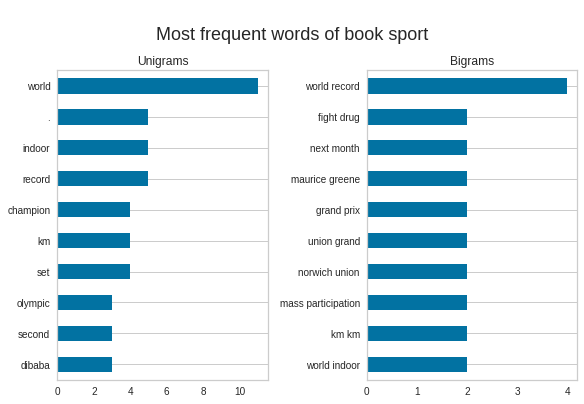

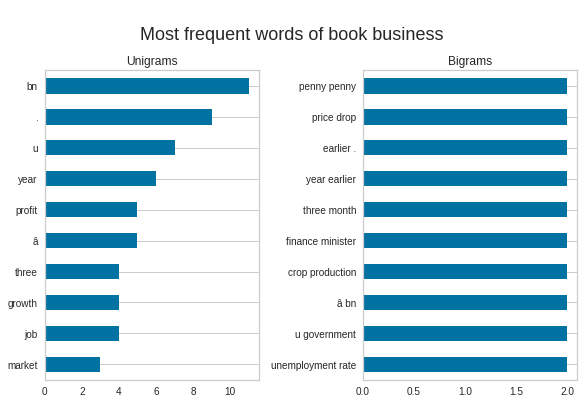

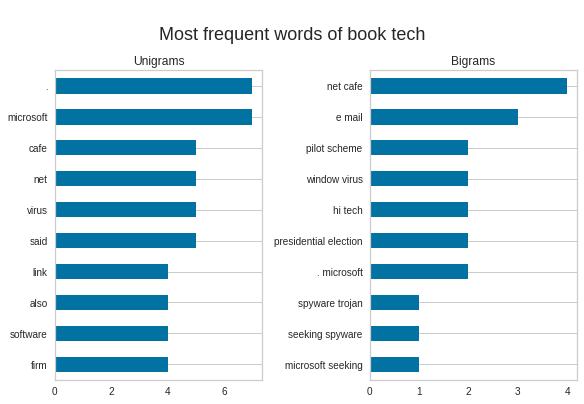

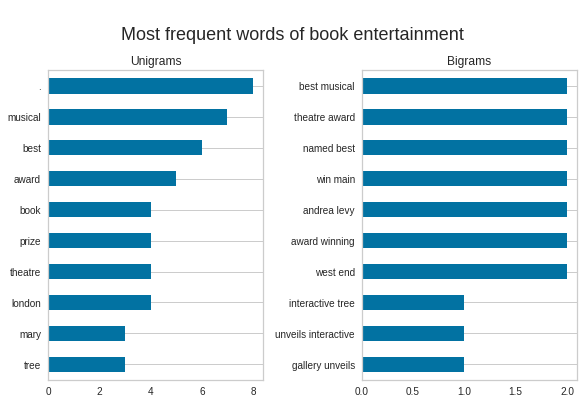

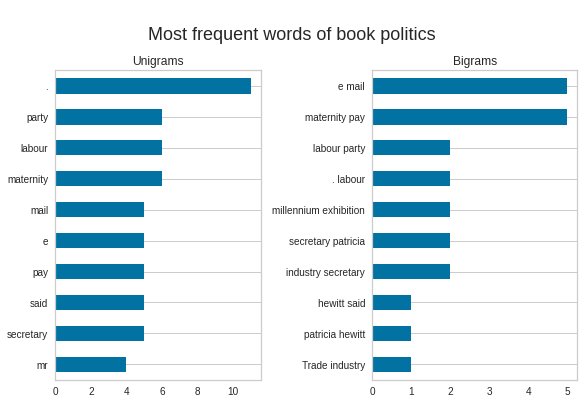

In [ ]:

df_top_word = [ ]
top= 10
for label in df_summary['labels'].unique():
    corpus = df_summary[df_summary["labels"]==label]["summary"]
    lst_tokens = nltk.tokenize.word_tokenize(corpus.str.cat(sep=" "))
    fig, ax = plt.subplots(nrows=1, ncols=2,constrained_layout=True)
    fig.suptitle(f"\n Most frequent words of book {label} ", fontsize=18)

    ## unigrams
    dic_words_freq = nltk.FreqDist(lst_tokens)
    df_uni = pd.DataFrame(dic_words_freq.most_common(), 
                        columns=["Word","Freq"])
    df_uni_top = pd.DataFrame(dic_words_freq.most_common(50), 
                        columns=["Word","Freq"])
    df_top_word.extend (df_uni_top['Word'].to_numpy())
    #df_top.append(df_uni.set_index("Word").iloc[:top,:].sort_values(by="Freq"))
    
    df_uni.set_index("Word").iloc[:top,:].sort_values(by="Freq").plot(
                    kind="barh", title="Unigrams", ax=ax[0], 
                    legend=False).grid(axis='x')
    ax[0].set(ylabel=None)
    ## bigrams
    dic_words_freq = nltk.FreqDist(nltk.ngrams(lst_tokens, 2))
    df_bi = pd.DataFrame(dic_words_freq.most_common(), 
                        columns=["Word","Freq"])
    df_bi["Word"] = df_bi["Word"].apply(lambda x: " ".join(
                    string for string in x) )
    df_bi.set_index("Word").iloc[:top,:].sort_values(by="Freq").plot(
                    kind="barh", title="Bigrams", ax=ax[1],
                    legend=False).grid(axis='x')
    ax[1].set(ylabel=None)



In [ ]:
from nltk.translate.bleu_score import sentence_bleu

In [ ]:
scores = []
for i , j in zip(df_summary["summary"] , df_summary["articles"]):
  scores.append(sentence_bleu(j, i))
scores

/usr/local/lib/python3.7/dist-packages/nltk/translate/bleu_score.py:490: UserWarning: 
Corpus/Sentence contains 0 counts of 2-gram overlaps.
BLEU scores might be undesirable; use SmoothingFunction().
  warnings.warn(_msg)


[0.5820255517991277,
 0.5598138844866251,
 0.5692994482485313,
 0.5800545598952107,
 0.5512925482675254,
 0.537284965911771,
 0.583526016818016,
 0.5455197616824397,
 0.5991486287298579,
 0.5635704938896392,
 0.5432685045633306,
 0.5623413251903491,
 0.5271017464925504,
 0.605965375922802,
 0.5930651136733044,
 0.5358948249862983,
 0.5725184614303233,
 0.5560762926236327,
 0.5787533178555756,
 0.5348787927553791,
 0.5485817327849255,
 0.5296364312689513,
 0.5270632227030374,
 0.5300714512917181,
 0.5396425695493028,
 0.5440203803169456,
 0.5480206379188944,
 0.5528019032338956,
 0.5344039775579892,
 0.5339312623872917,
 0.5496692089125195,
 0.5623413251903491,
 0.5415664594883131,
 0.5914152197793631,
 0.5435251404952659,
 0.5595642461260144,
 0.5507404268455894,
 0.5463002910485316,
 0.5773502691896257,
 0.567740420976129,
 0.5276093714990412,
 0.5336172773868456,
 0.5386933265263314,
 0.5257997780053305,
 0.5699251675825919,
 0.5894100159395204,
 0.5516251532744788,
 0.56576691298823

In [ ]:
article_name = [ '1' , '2' ,'3','4','5','6','7','8', '9' , '10' , '11' ,'12','13' , '14','15','16',
                '17','18','19','20','21','22','23','24','25','26', '27' ,'28' ,'29', '30', '31', '32' ,
                '33' ,'34', '35', '36' ,'37' ,'38' ,'39' , '40' ,'41', '42', '43', '44', '45', '46', '47' ,'48' ,'49' ,'50']
plt.figure(figsize=(12,7))
axis_1 = plt.plot(scores, color='blue', marker='o', 
                  linestyle='dashdot')
plt.xlabel('article_name')
plt.ylabel('Blue Scores %')
plt.show